# CNN Image Classification Laboration


Images used in this laboration are from [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. 

Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

Complete the code flagged throughout the elaboration and **answer all the questions in the notebook**.

In [2]:
# Setups
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2

# Part 1: Convolutions

In the next sections you will familiarize yourself with 2D convolutions.

## 1.1 What is a convolution?

To understand a bit more about convolutions, we will first test the convolution function in `scipy` using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function `convolve2d` in `signal` from scipy (see the [documentation](https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.signal.convolve2d.html
) for more details).


In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation (which is in contrast to traditional image processing, where the filters are designed by an expert).

Run the cell below to define a Gaussian filter and a Sobel X and Y filters.

In [3]:
from scipy import signal
import numpy as np

# Get a test image
from scipy import datasets
image = datasets.ascent()

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)
# A Gaussian filter is used for smoothing the image. 
# In this case, the filter size is (15, 15) with a standard deviation of 4.

# Mainly used to remove noise from an image while preserving the overall structure of the image.
# A smoothing effect is achieved by reducing high frequency noise in an image by weighting the average pixel values.

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 
# Used to detect vertical edges in an image 
# because the pixel variation in the horizontal direction is greatest at vertical edges.
# Vertical edges will be more visible in the output image.

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 
# Used to detect horizontal edges in an image 
# because the pixel variation in the vertical direction is greatest at horizontal edges.
# Horizontal edges will be more visible in the output image.

In [4]:
# --------------------------------------------
# === Your code here =========================
# -------------------------------------------- 
# Perform convolution using the function 'convolve2d' for the different filters

filterResponseGauss = signal.convolve2d(image, gaussFilter, mode='full', boundary='fill', fillvalue=0)
filterResponseSobelX = signal.convolve2d(image, sobelX, mode='full', boundary='fill', fillvalue=0)
filterResponseSobelY = signal.convolve2d(image, sobelY, mode='full', boundary='fill', fillvalue=0)

# ============================================

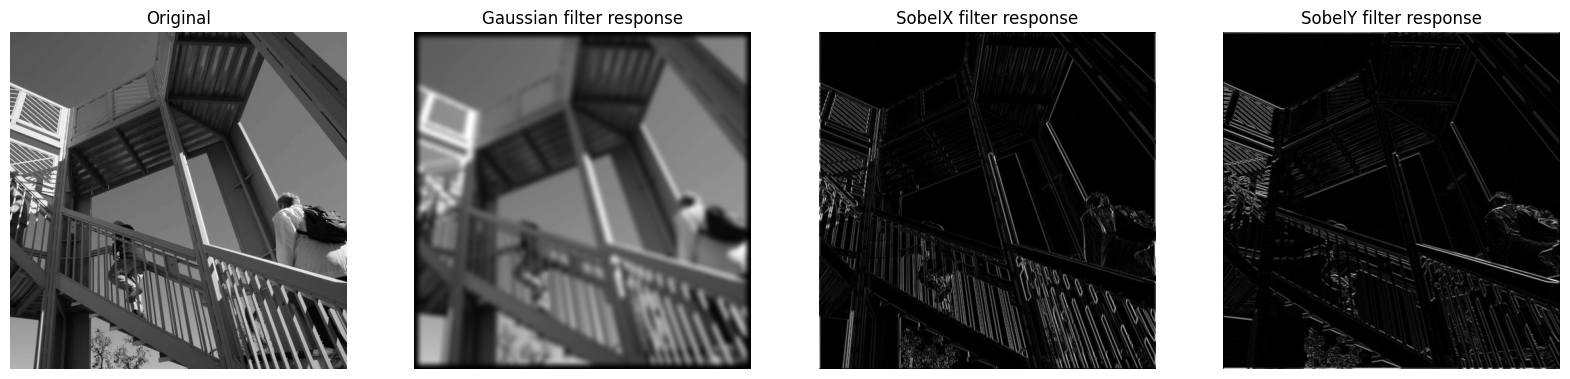

In [5]:
import matplotlib.pyplot as plt

# Show filter responses
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Gaussian filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('SobelX filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('SobelY filter response')
ax_filt3.set_axis_off()

## 1.2 Understanding convolutions

#### **<span style="color:red">Questions</span>**

1. What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

2. What is the size of the original image? How many channels does it have? How many channels does a color image normally have?

3. What is the size of the different filters?

4. What is the size of the filter response if mode 'same' is used for the convolution ?

5. What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter? 

6. Why are 'valid' convolutions a problem for CNNs with many layers?

#### **<span style="color:green">Answers</span>**
1. Gaussian filter would blur the image, suppress high-frequency noise, smooth the overall. Vertical edges (e.g. left and right boundaries of an object) are shown as bright lines after SobelX filter. Horizontal edges (such as the top and bottom boundaries of an object) are displayed as bright lines after SobelY.

2. The channel of the grey image is 1, while the number for colorful image should be 3 generally.

3. The size of Gaussian filter is (15, 15), others are (3, 3)

4. We take Gaussian filter for example, the size of filter response is (512, 512)

5. The size of filter response for Gaussian filter decreases to (498, 498), while the figures for the other two are (510, 510). The reason is the center of the filter must always lie within the valid region of the input image, when the filter is close to the edge of the image, some of its regions go beyond the input boundaries (without padding), so the number of slides actually available is reduced. As for how the size of filter affects the size of response in the 'valid' mode, the rule is like: 

$$Output Height=H-K_h+1$$

$$Output Width=W-K_w+1$$

where, H and W are input height and width respectively, and $K_h$ and $K_w$ are filter height and width. 
 
6. Because there is no any padding for the response, the size of response would decrease after layers. It may decreases to (1, 1), which cannot go through another layer. Except that, as mentioned reason, it would lose the edge information, affecting the performance of the model. 

In [6]:
# --------------------------------------------
# === Your code here =========================
# -------------------------------------------- 
# Your code for checking sizes of image and filter responses
print(f"The dimension of image is: {image.shape}")
filterResponse_test = signal.convolve2d(image, gaussFilter, mode='same', boundary='fill', fillvalue=0)
print(f"The dimension of filter response of Gaussian filter with parameter mode='same' is {filterResponse_test.shape}")
filterResponse_valid_test1 = signal.convolve2d(image, gaussFilter, mode='valid', boundary='fill', fillvalue=0)
print(f"The dimension of filter response of Gaussian filter with parameter mode='valid' is {filterResponse_valid_test1.shape}")

filterResponse_valid_test2 = signal.convolve2d(image, sobelX, mode='valid', boundary='fill', fillvalue=0)
print(f"The dimension of filter response of SobelX filter with parameter mode='valid' is {filterResponse_valid_test2.shape}")

filterResponse_valid_test3 = signal.convolve2d(image, sobelY, mode='valid', boundary='fill', fillvalue=0)
print(f"The dimension of filter response of SobelY filter with parameter mode='valid' is {filterResponse_valid_test3.shape}")

# ============================================

The dimension of image is: (512, 512)
The dimension of filter response of Gaussian filter with parameter mode='same' is (512, 512)
The dimension of filter response of Gaussian filter with parameter mode='valid' is (498, 498)
The dimension of filter response of SobelX filter with parameter mode='valid' is (510, 510)
The dimension of filter response of SobelY filter with parameter mode='valid' is (510, 510)


#  Part 2: Get a graphics card

Skip the next cell if you run on the CPU.

If your computer has a dedicated graphics card and you would like to use it, we need to make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [7]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# This sets the GPU to allocate memory only as needed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 
    print("Running on GPU")
else:
    print('No GPU available.')

E0000 00:00:1742508705.466229  209457 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742508705.469249  209457 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


No GPU available.


## How fast is the graphics card?


#### **<span style="color:red">Questions</span>**

7. Why are the filters used for a color image of size 7 x 7 x 3, and not 7 x 7 ? 

8. What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?

9.  Pretend that everyone is using an Nvidia RTX 3090 graphics card, how many CUDA cores does it have? How much memory does the graphics card have?

10. How much memory does the graphics card have?

11. What is stored in the GPU memory while training a CNN?

12. Do you think that a graphics card, compared to the CPU, is equally faster for convolving a batch of 1,000 images, compared to convolving a batch of 3 images? Motivate your answer.


#### **<span style="color:green">Answers</span>**
7. Colorful images need channels to represent the color information. (7, 7) represents grey images.

8.  The Conv2D layer performs a two-dimensional Cross-Correlation rather than a mathematically strict Convolution. The difference between the two is whether the filter flips.

9. Number of CUDA cores: 10496, graphics memory capacity 24GB.

10. If it is Nvidia RTX 3060, it is 24GB.

11. Weights of model, the present batch of data and labels, gradients and activations.

12. I don't think so. When the batch size is 3, many GPU cores remain unoccupied, meaning it cannot fully leverage parallel computing. Additionally, transferring data to the GPU takes time. In this case, I don't believe the GPU is necessarily faster than the CPU for a task with a batch size of 3.

# Part 3: Dataset

In the following section you will load the CIFAR10 dataset, check few samples, perform some preprocessing on the images and the labels, and split the data into training, validation and testing.

## 3.1 Load the dataset

Run the following section to load the CIFAR10 data, take a total of 10.000 training/validation samples and 2000 testing samples. 

In [27]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(X, Y), (Xtest, Ytest) = cifar10.load_data()

print("Training/validation images have size {} and labels have size {} ".format(X.shape, Y.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training/validation and testing to 10000 and 2000 respectively, 
# to reduce processing time for this elaboration. 
X = X[0:10000]
Y = Y[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training/validation images have size %s and labels have size %s " % (X.shape, Y.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training/validation examples for class {} is {}" .format(i,np.sum(Y == i)))

Training/validation images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training/validation images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training/validation examples for class 0 is 1005
Number of training/validation examples for class 1 is 974
Number of training/validation examples for class 2 is 1032
Number of training/validation examples for class 3 is 1016
Number of training/validation examples for class 4 is 999
Number of training/validation examples for class 5 is 937
Number of training/validation examples for class 6 is 1030
Number of training/validation examples for class 7 is 1001
Number of training/validation examples for class 8 is 1025
Number of training/validation examples for class 9 is 981


Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

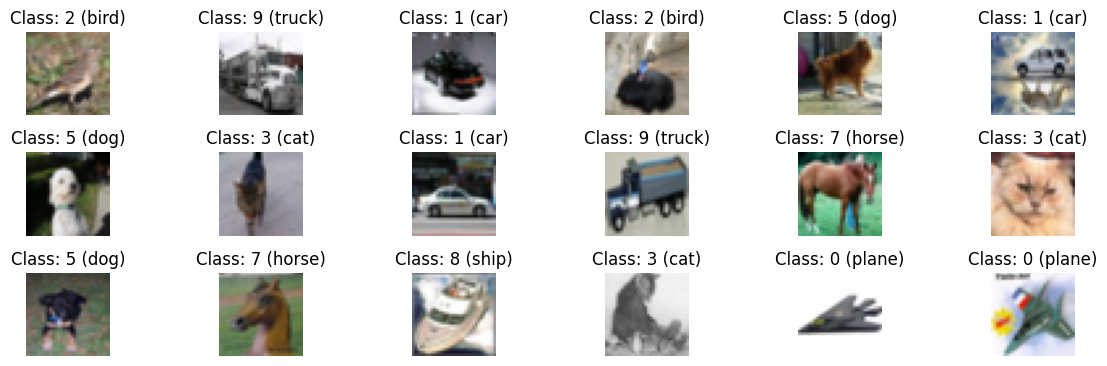

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Y[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(X[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##  3.2 Split data into training, validation and testing
Split your data (X, Y) into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration).

We use the `train_test_split` function from scikit learn (see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for more details) to obtain 25% validation set.

In [29]:
from sklearn.model_selection import train_test_split

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# split the original dataset into 70% Training and 30% Temp
Xtrain, X_temp, Ytrain, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)



# Print the size of training data, validation data and test data
Xval, Xtest, Yval, Ytest = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# ============================================
print(f"Training set size: {len(Xtrain)}")
print(f"Validation set size: {len(Xval)}")
print(f"Test set size: {len(Xtest)}")

Training set size: 7000
Validation set size: 1500
Test set size: 1500


## 3.3 Image Preprocessing

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255.

In [30]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  3.4 Label preprocessing

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use the `to_categorical`function in Keras (see the [documentation](https://keras.io/api/utils/python_utils/#to_categorical-function) for details on how to use it)

In [31]:
from tensorflow.keras.utils import to_categorical

# Print shapes before converting the labels
print('Ytrain has size {}.'.format(Ytrain.shape))
print('Yval has size {}.'.format(Yval.shape))
print('Ytest has size {}.'.format(Ytest.shape))


# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
num_classes = Ytrain.max() + 1 
# Your code for converting Ytrain, Yval, Ytest to categorical
Ytrain = to_categorical(Ytrain, num_classes)
Yval = to_categorical(Yval, num_classes)
Ytest = to_categorical(Ytest, num_classes)


# Print shapes after converting the labels
print('After one-hot encoding:')
print('Ytrain has size {}.'.format(Ytrain.shape))
print('Yval has size {}.'.format(Yval.shape))
print('Ytest has size {}.'.format(Ytest.shape))

# ============================================

Ytrain has size (7000, 1).
Yval has size (1500, 1).
Ytest has size (1500, 1).
After one-hot encoding:
Ytrain has size (7000, 10).
Yval has size (1500, 10).
Ytest has size (1500, 10).


# Part 4: 2D CNN

In the following sections you will build a 2D CNN model and will train it to perform classification on the CIFAR10 dataset. 

## 4.1 Build CNN model

Start by implementing the `build_CNN` function in the `utilities.py` file. Below you can find the specifications on how your `build_CNN` function should build the model:
- Each convolutional layer is composed by: `2D convolution` -> `batch normalization` -> `max pooling`.
- The `2D convolution` uses a 3 x 3 kernel size, padding='same' and a number of starting filter that is an input to the `build_CNN` function. The number of filters doubles with each convolutional layer (e.g. 32, 64, 128, etc.)
- The max pooling layers should have a pool size of 2 x 2.
- After the convolutional layers comes a flatten layer, followed by a number of intermediate dense layers. 
- The number of nodes in the intermediate dense layers before the final dense layer is an input to the `build_CNN` function. The intermediate dense layers use `relu` activation functions and each is followed by `batch normalization`.
- The final dense layer should have 10 nodes (=the number of classes in this elaboration) and `softmax` activation. 

Here are some relevant functions that you should use in `build_CNN`. For a complete list of functions and their definitions see the [keras documentation](https://keras.io/api/):

- `model.add()`, adds a layer to the network;
- `Dense()`, a dense network layer. See the [documentation](https://keras.io/api/layers/core_layers/dense/) what are the input options and outputs of the `Dense()` function. 
- `Conv2D()` performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3) (see [documentation](https://keras.io/api/layers/convolution_layers/convolution2d/)). 
- `BatchNormalization()`, perform batch normalization (see [documentation](https://keras.io/api/layers/normalization_layers/batch_normalization/)).
- `MaxPooling2D()`, saves the max for a given pool size, results in down sampling (see [documentation](https://keras.io/api/layers/pooling_layers/max_pooling2d/)).
- `Flatten()`, flatten a multi-channel tensor into a long vector (see [documentation](https://keras.io/api/layers/reshaping_layers/flatten/)).
- `model.compile()`, compiles the model. You can set the input metrics=['accuracy'] to print the classification accuracy during the training.
- cost and loss functions: check the [documentation](https://keras.io/losses/) and chose a loss function for binary classification.

To get more information in model [compile](https://keras.io/api/models/model_training_apis/#compile-method), [training](https://keras.io/api/models/model_training_apis/#fit-method) and [evaluation](https://keras.io/api/models/model_training_apis/#evaluate-method) see the relevant documentation.

Here you can start with the `Adam` optimizer when compiling the model.

Use the following cell to test your `build_CNN` utility function. Remember to import a relevant cost function for multi-class classification from [keras.losses](https://keras.io/losses/) which relates to how many classes you have.

In [14]:
# import utilities
from utilities import build_CNN

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# import a suitable loss function from keras.losses and use as input to the build_DNN function.
from tensorflow.keras.losses import CategoricalCrossentropy

input_shape = Xtest[1].shape
# print(f"input shape is {input_shape}")
# Build a DNN model following the specifications above
model = build_CNN(input_shape, CategoricalCrossentropy())

# ============================================

/opt/liu/course-venv-732a82/2/1/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 4.2 Train 2D CNN

Time to train the CNN!

Start with a model with 2 convolutional layers where the first layer has have 16 filters, and with no intermediate dense layers.

Set the training parameters, build the model and run the training. 

Use the following training parameters:
- `batch_size=20`
- `epochs=20`
- `learning_rate=0.01`

Relevant functions:
- `build_CNN`, the function that you defined in the `utilities.py` file.
- `model.fit()`, train the model with some training data (see [documentation](https://keras.io/api/models/model_training_apis/#fit-method)).
- `model.evaluate()`, apply the trained model to some test data (see [documentation](https://keras.io/api/models/model_training_apis/#evaluate-method)).

## 2 convolutional layers, no intermediate dense layers

In [14]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Setup some training parameters
batch_size = 20
epochs = 20
input_shape = input_shape
learning_rate = 0.01

# Build model
model1 = build_CNN(input_shape=input_shape, 
                   loss=CategoricalCrossentropy(), 
                   learning_rate=learning_rate)

# Train the model  using training data and validation data
history1 = model1.fit(Xtrain, 
                      Ytrain, 
                      validation_data=(Xval, Yval), 
                      epochs=epochs, 
                      batch_size=batch_size)

# ============================================

Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1740 - loss: 2.2178 - val_accuracy: 0.2873 - val_loss: 1.9357
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3222 - loss: 1.9039 - val_accuracy: 0.3560 - val_loss: 1.7819
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3780 - loss: 1.7423 - val_accuracy: 0.3780 - val_loss: 1.6899
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4238 - loss: 1.6333 - val_accuracy: 0.4260 - val_loss: 1.5758
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4571 - loss: 1.5288 - val_accuracy: 0.4480 - val_loss: 1.5521
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4628 - loss: 1.4925 - val_accuracy: 0.4660 - val_loss: 1.4861
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5075 - loss: 1.4039 - val_accuracy: 0.4667 - val_loss: 1.4654
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5151 - loss: 1.3604 - val_accuracy: 0.

In [15]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(Xtest, Ytest, batch_size=batch_size)

# ============================================

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 1.3005  
Test loss: 1.3333
Test accuracy: 0.5567


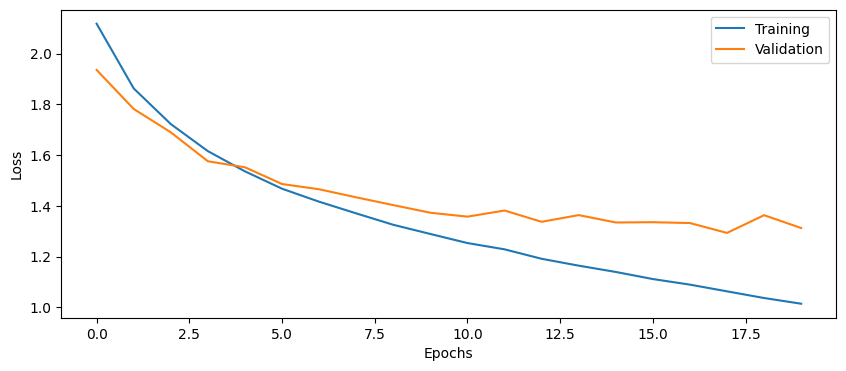

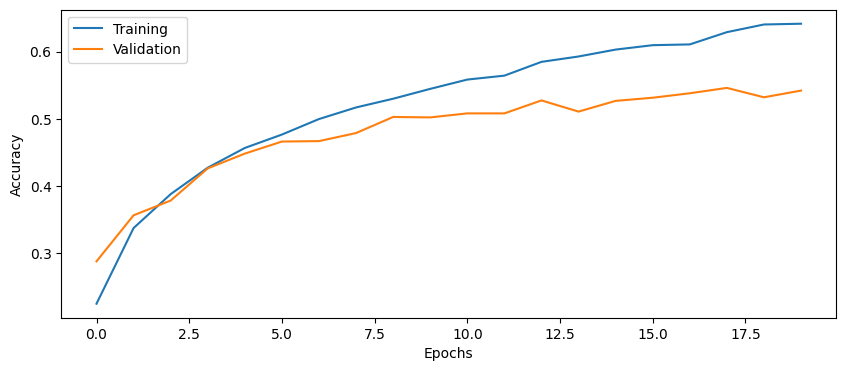

In [16]:
from utilities import plot_results
# Plot the history from the training run
plot_results(history1)

##  4.3 Improving model performance

Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%)? 

#### **<span style="color:red">Questions</span>**
13. How big is the difference between training and test accuracy?

14. For the DNN elaboration we used a batch size of 10.000, why do we need to use a smaller batch size in this elaboration?

#### **<span style="color:green">Answers</span>**

Test accuracy is 55%, quite low honestly.

13. The difference between train accuracy and test accuracy is 10%.

14. Bigger batch size would spend more time and occupy more memory on loading the batch and calculating gradients. In this case, the information in images is much more than figures, smaller batch size may release the burden of computational resource.

Experiment with several model configurations in the following sections. 

### 2 convolutional layers with 16 starting filters and 1 intermediate dense layer (50 nodes)

Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1632 - loss: 2.2535 - val_accuracy: 0.2860 - val_loss: 2.0231
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3106 - loss: 1.9518 - val_accuracy: 0.3600 - val_loss: 1.7947
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3712 - loss: 1.7626 - val_accuracy: 0.3913 - val_loss: 1.6782
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4278 - loss: 1.6257 - val_accuracy: 0.3960 - val_loss: 1.6255
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4384 - loss: 1.5420 - val_accuracy: 0.4473 - val_loss: 1.5036
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4752 - loss: 1.4539 - val_accuracy: 0.4613 - val_loss: 1.4780
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5014 - loss: 1.4102 - val_accuracy: 0.4547 - val_loss: 1.4513
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5098 - loss: 1.3688 - val_accuracy: 0.

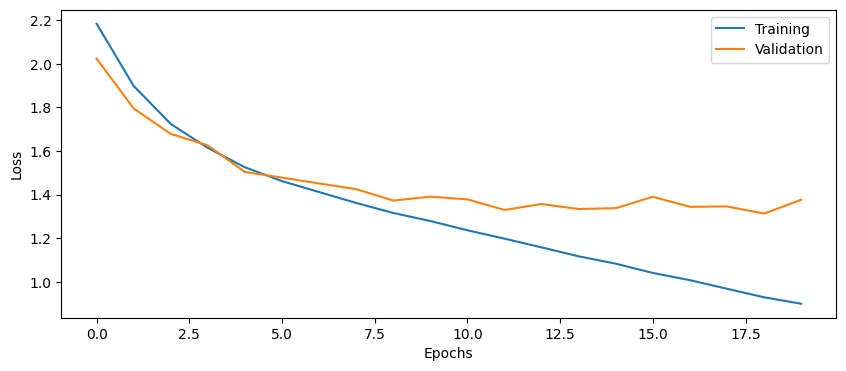

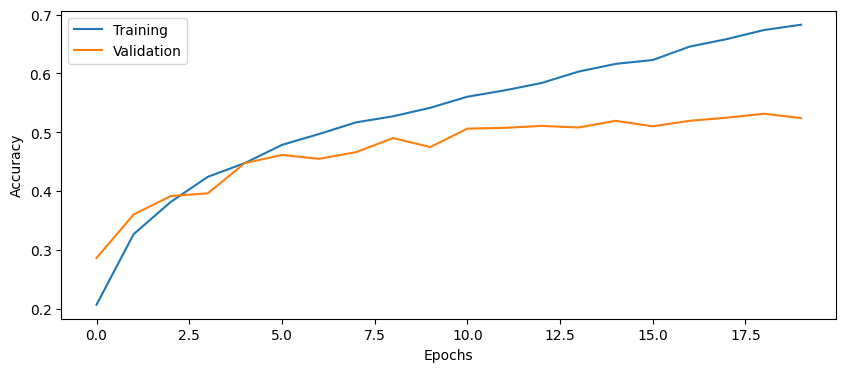

In [17]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Build and train model
model1 = build_CNN(input_shape=input_shape, 
                   loss=CategoricalCrossentropy(), 
                   learning_rate=learning_rate,
                   n_dense_layers=1)

history1 = model1.fit(Xtrain, 
                      Ytrain, 
                      validation_data=(Xval, Yval), 
                      epochs=epochs, 
                      batch_size=batch_size)

# Evaluate model on test data
score = model1.evaluate(Xtest, Ytest, batch_size=batch_size)

# ============================================

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Plot the history from the training run
plot_results(history1)

### 4 convolutional layers with 16 starting filters and 1 intermediate dense layer (50 nodes)

Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1235 - loss: 2.3011 - val_accuracy: 0.1873 - val_loss: 2.2488
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1870 - loss: 2.2033 - val_accuracy: 0.2700 - val_loss: 1.9794
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2927 - loss: 1.9521 - val_accuracy: 0.3267 - val_loss: 1.8113
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3466 - loss: 1.8126 - val_accuracy: 0.3613 - val_loss: 1.7261
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3762 - loss: 1.7065 - val_accuracy: 0.3973 - val_loss: 1.6398
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3815 - loss: 1.6678 - val_accuracy: 0.4187 - val_loss: 1.5742
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4173 - loss: 1.5959 - val_accuracy: 0.4380 - val_loss: 1.5182
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4351 - loss: 1.5426 - val_accuracy: 0.

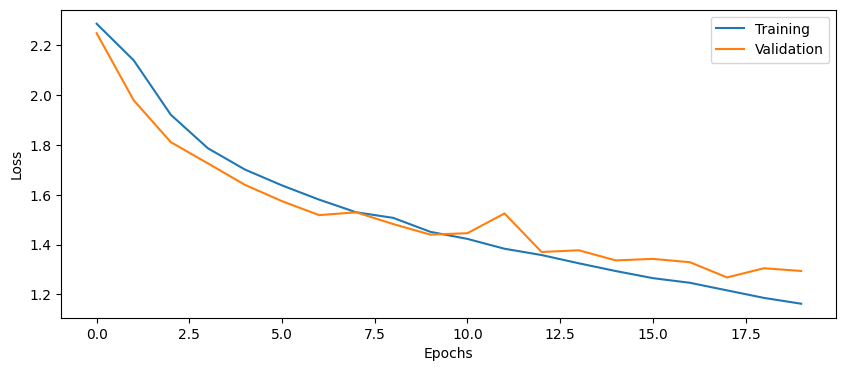

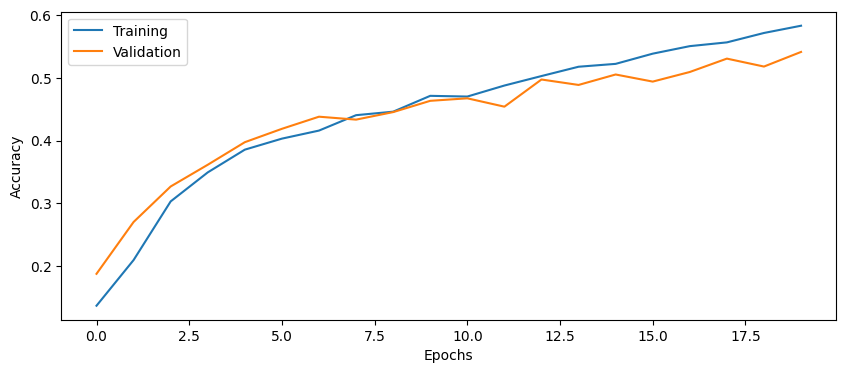

In [18]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Build and train model
model2 = build_CNN(input_shape=input_shape, 
                   loss=CategoricalCrossentropy(), 
                   learning_rate=learning_rate,
                   n_dense_layers=1,
                   n_conv_layers=4)

history2 = model2.fit(Xtrain, 
                      Ytrain, 
                      validation_data=(Xval, Yval), 
                      epochs=epochs, 
                      batch_size=batch_size)

# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest, batch_size=batch_size)

# ============================================

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Plot the history from the training run
plot_results(history2)

## 4.4 Plot the CNN architecture and understand the internal model dimensions

To understand your network better, print the architecture using `model.summary()`

#### **<span style="color:red">Questions</span>**

15. How many trainable parameters does your network have? Which part of the network contains most of the parameters?
    
16. What is the input to and output of a Conv2D layer? What are the dimensions of the input and output? 
17. Is the batch size always the first dimension of each 4D tensor? Check the [documentation](https://keras.io/layers/convolutional/) for Conv2D.
18. If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?
19. Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?
20. How does MaxPooling help in reducing the number of parameters to train?

#### **<span style="color:green">Answers</span>**
15. The number of parameters is 13,018. The second convolutional layer contains the most parameters.

16. Take the first convolutional layer for example, the input is encoded image and its output is the features, the dimension of input is (32, 32, 3) and the dimension of output is (32, 32, 16).

17. Yes! Alough the parameter input size is (32, 32, 3), the batch size would be finally added in the first place.

18. The output channels would be equal to the filters number. 

19. The number of parameters in convolutional layer should be (kernel size * input_channels + 1) * filter number, which represents the whole input (channel=3 in our model) should be convolved by each filter. The question ignores the input_channel.

20. The Maxpooling select the maximum value in the pool as the new feature, which equals to transform 4 value (maxpooling(2,2)) as 1.


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,018 (50.85 KB)

 Trainable params: 13,018 (50.85 KB)

 Non-trainable params: 0 (0.00 B)

##  4.5 Dropout regularization

Add dropout regularization between each intermediate dense layer, with dropout probability 50%.

#### **<span style="color:red">Questions</span>**

21. How much did the test accuracy improve with dropout, compared to without dropout?

22. What other types of regularization can be applied? How can you add `L2 regularization` for the convolutional layers?
 
#### **<span style="color:green">Answers</span>**
21. Nothing improvement on test accuracy, I think the model is still in a state of underfitting.

22. We can take some methods like L1-regularization, L2-regularization, early stop, and data augmentation. We can set the parameter in Conv2D: kernel_regularizer= regularizer.l2() and set the hyperparameter in parentheses.


### 4 convolutional layers with 16 starting filters and 1 intermediate dense layer (50 nodes) with dropout

Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1178 - loss: 2.2924 - val_accuracy: 0.1620 - val_loss: 2.2131
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1793 - loss: 2.1967 - val_accuracy: 0.2407 - val_loss: 2.0783
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2020 - loss: 2.1104 - val_accuracy: 0.2820 - val_loss: 1.9681
Epoch 4/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2354 - loss: 2.0352 - val_accuracy: 0.2807 - val_loss: 1.9062
Epoch 5/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2679 - loss: 1.9498 - val_accuracy: 0.3473 - val_loss: 1.8016
Epoch 6/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2779 - loss: 1.9190 - val_accuracy: 0.3513 - val_loss: 1.7737
Epoch 7/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2825 - loss: 1.8705 - val_accuracy: 0.3793 - val_loss: 1.7216
Epoch 8/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3157 - loss: 1.8128 - val_accu

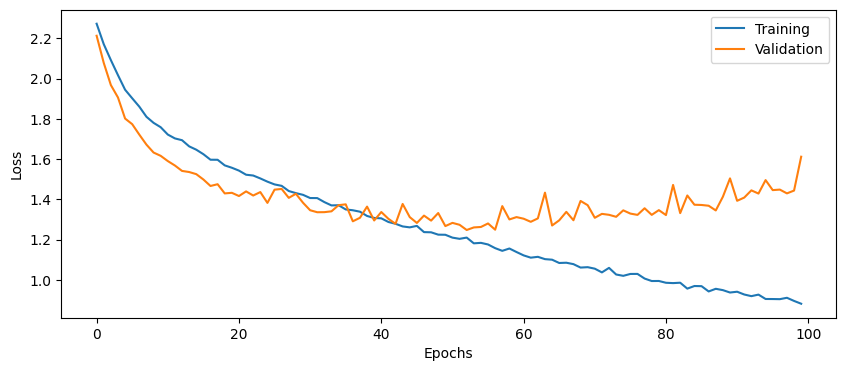

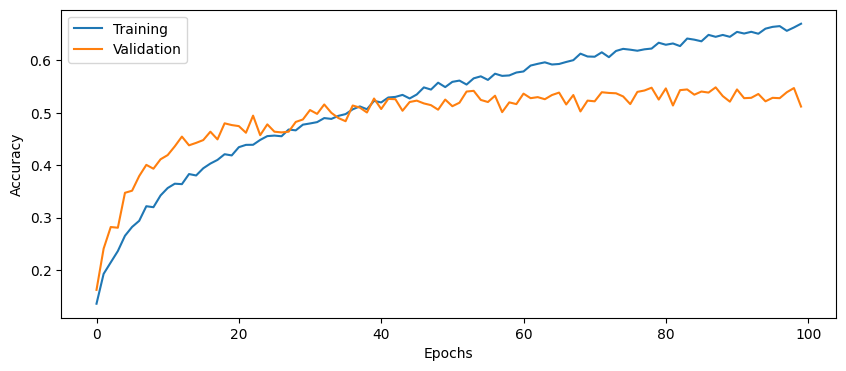

In [21]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Setup some training parameters
batch_size = 20
epochs = 100
input_shape = input_shape
learning_rate = 0.01

# Build and train model
model3 = build_CNN(input_shape=input_shape, 
                   loss=CategoricalCrossentropy(), 
                   learning_rate=learning_rate,
                   n_dense_layers=1,
                   n_conv_layers=4,
                   use_dropout=True)

# Train the model using training data and validation data
history3 = model3.fit(Xtrain, 
                      Ytrain, 
                      validation_data=(Xval, Yval), 
                      epochs=epochs, 
                      batch_size=batch_size)

# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest, batch_size=batch_size)

# ============================================

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

plot_results(history3)

##  4.6 Tweaking model performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

#### **<span style="color:red">Questions</span>**

23. How high test accuracy can you obtain? What is your best configuration?

#### **<span style="color:green">Answers</span>**
23. Unfortunately, 55% on test data, I used l2-regularization, dropout and adam optimizer.

## *Your best config*

Epoch 1/500
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1264 - loss: 3.1052 - val_accuracy: 0.2380 - val_loss: 2.4002
Epoch 2/500
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2146 - loss: 2.3624 - val_accuracy: 0.3367 - val_loss: 2.0950
Epoch 3/500
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2843 - loss: 2.1325 - val_accuracy: 0.3453 - val_loss: 1.9641
Epoch 4/500
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2935 - loss: 2.0456 - val_accuracy: 0.3753 - val_loss: 1.8848
Epoch 5/500
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3223 - loss: 1.9583 - val_accuracy: 0.4127 - val_loss: 1.8145
Epoch 6/500
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3485 - loss: 1.8989 - val_accuracy: 0.3793 - val_loss: 1.7946
Epoch 7/500
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3654 - loss: 1.8650 - val_accuracy: 0.4100 - val_loss: 1.7528
Epoch 8/500
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3565 - loss: 1.8452 - val_accu

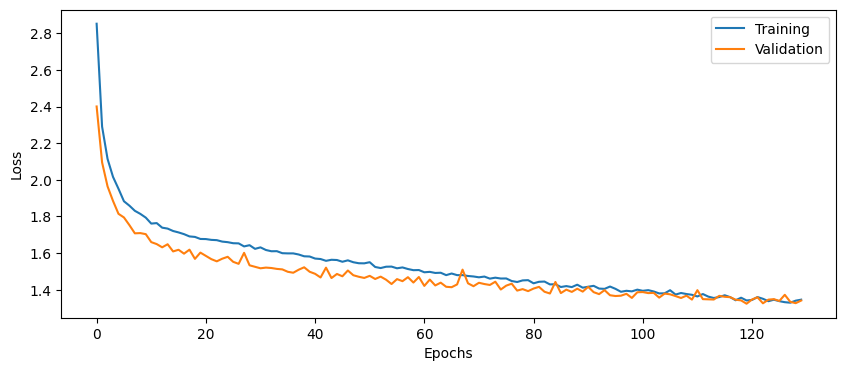

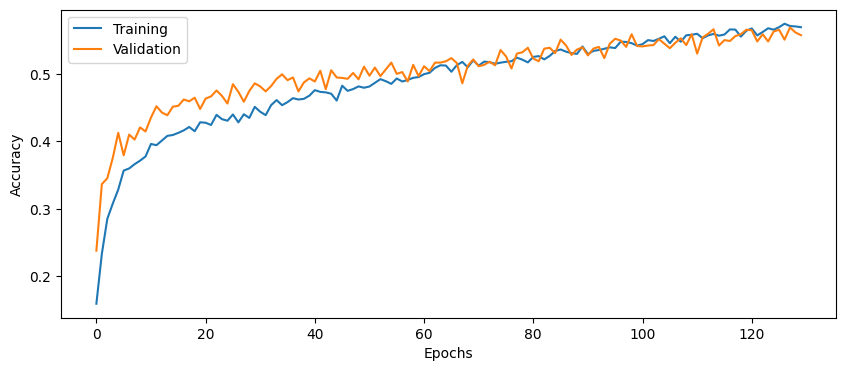

In [22]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping
# Setup some training parameters
batch_size = 32
epochs = 500
input_shape = input_shape
learning_rate = 0.0005

# Build and train model. Here experiment with several model architecture configurations to obtain the best performance.
model4 = build_CNN(input_shape=input_shape, 
                   loss=CategoricalCrossentropy(), 
                   learning_rate=learning_rate,
                   n_dense_layers=1,
                   n_conv_layers=3,
                   use_dropout=True,
                   l2_regularization=True,
                   optimizer='adam')

# early stop
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,          
                               restore_best_weights=True)  

history4 = model4.fit(Xtrain, 
                      Ytrain, 
                      validation_data=(Xval, Yval), 
                      epochs=epochs, 
                      batch_size=batch_size,
                      callbacks=[early_stopping])

# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest, batch_size=batch_size)


# ============================================

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Plot the history from the training run
plot_results(history4)

# Part 5: Model generalization

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

#### **<span style="color:red">Questions</span>**

24. What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.

#### **<span style="color:green">Answers</span>**
Test accuracy is extremely low (0.20), performing substantially worse than a random guess. Since CNN learns filters that detect features like edges and shapes, when images are rotated it creates a domain shift - it didn't learn how to recognize features in this orientation.

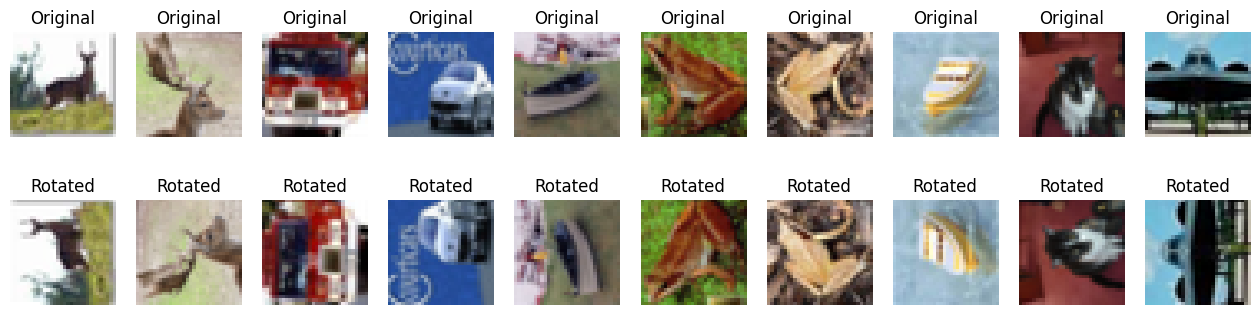

In [20]:
from utilities import myrotate
# Visualize some rotated images
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [24]:
# Evaluate the trained model on rotated test set
score = model4.evaluate(Xtest_rotated, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 3.0628
Test accuracy: 0.2087


##  5.1 Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`. In particular, we will use the `flow()` functionality (see the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for more details).

Make sure to use different subsets for training and validation when you calling `flow()` on the training data generator in `model.fit()`, otherwise you will validate on the same data. 

In [15]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own

# re-load the CIFAR10 train and test data
(X, Y), (Xtest, Ytest) = cifar10.load_data()

# Reduce the number of images for training/validation and testing to 10000 and 2000 respectively, 
# to reduce processing time for this elaboration. 
X = X[0:10000]
Y = Y[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

# Change data type and rescale range
X = X.astype('float32')
Xtest = Xtest.astype('float32')

X = X / 127.5 - 1
Xtest = Xtest / 127.5 - 1


# Convert labels to hot encoding
Y = to_categorical(Y, 10)
Ytest = to_categorical(Ytest, 10)

print("Training/validation images have size {} and labels have size {} ".format(X.shape, Y.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

Training/validation images have size (10000, 32, 32, 3) and labels have size (10000, 10) 
Test images have size (2000, 32, 32, 3) and labels have size (2000, 10) 
 


In [16]:
from tf_keras.preprocessing.image import ImageDataGenerator

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Use a rotation range of 30 degrees, horizontal and vertical flipping
# Set up image data generator
image_dataset = ImageDataGenerator(rotation_range=30, horizontal_flip=True, vertical_flip=True)

train_flow = image_dataset.flow(X,Y, batch_size=1)

# ============================================


#### **<span style="color:red">Questions</span>**

25. How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?

#### **<span style="color:green">Answers</span>**
One could use flow_from_directory("path/to/train/data", target_size=(nn,nn), batch_size=nn, class_mode="categorical") - but disk is slower than memory, so might result in slower training.

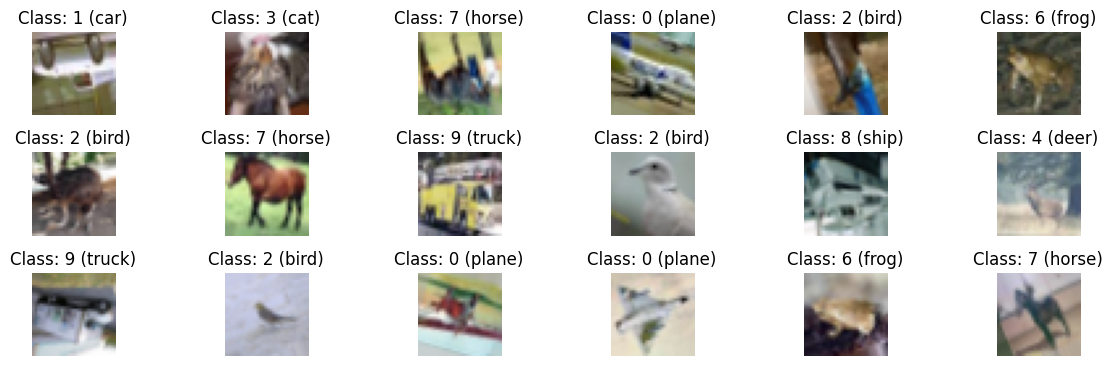

In [17]:
# Plot some augmented images

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = train_flow.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## 5.2 Train the CNN with images from the generator

Check the documentation for the [`model.fit`](https://keras.io/api/models/model_training_apis/#fit-method) method how to use it with a generator instead of a fix dataset (numpy arrays).

To make the comparison fair to training without augmentation

- `steps_per_epoch` should be set to: `len(Xtrain)/batch_size`
- `validation_steps` should be set to: `len(Xval)/batch_size`
    
This is required since with a generator, the fit function will not know how many examples your original dataset has.

#### **<span style="color:red">Questions</span>**

26. How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. We are here talking about the number of training epochs required to reach a certain accuracy, and not the training time in seconds. What parameter is necessary to change to perform more training?

27. What other types of image augmentation can be applied, compared to what we use here?

#### **<span style="color:green">Answers</span>**
26. Training accuracy increases slower in comparison, because it takes more epochs for the model to reach a certain training accuracy - each epoch sees different versions of the same pictures. It is a sort of regularization.

27. One can zoom, shear, adjust brightness, contrast, shift channels, width and height, for instance.

In [18]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Setup training parameters
batch_size = 64
epochs = 500
input_shape = Xtest[1].shape

# Build model (your best config)
model6 = build_CNN(
    input_shape=input_shape, 
    loss=CategoricalCrossentropy(),
    learning_rate=0.0005, 
    n_dense_layers=1, 
    n_conv_layers=3,
    use_dropout=True, 
    l2_regularization=True, 
    optimizer="adam"
)

# A workaround converting NumpyArrayIterator to a standard generator yielding batches indefinitely - otherwise there's an error
def wrap_iterator(numpy_iterator):
    while True:
        X_batch, Y_batch = next(numpy_iterator)
        yield X_batch, Y_batch

X_train = X[:8000]
Y_train = Y[:8000]
X_val   = X[8000:]
Y_val   = Y[8000:]

# Set up training and validation dataset flows from image_dataset
# flow() for training data
train_flow = image_dataset.flow(X_train, Y_train, batch_size=batch_size)

# flow() for validation data
val_flow = image_dataset.flow(X_val, Y_val, batch_size=batch_size)

# Wrapping iterator - otherwise there's an error
train_gen = wrap_iterator(train_flow)
val_gen = wrap_iterator(val_flow)

# Train the model using on the fly augmentation
history6 = model6.fit(
    train_gen,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=val_gen,
    validation_steps=len(X_val) // batch_size,
    epochs=epochs
)

# ============================================

Epoch 1/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1373 - loss: 3.1752 - val_accuracy: 0.2127 - val_loss: 2.5857
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2004 - loss: 2.5030 - val_accuracy: 0.2273 - val_loss: 2.2920
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2107 - loss: 2.2846 - val_accuracy: 0.2450 - val_loss: 2.1897
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2262 - loss: 2.1862 - val_accuracy: 0.2753 - val_loss: 2.1089
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2413 - loss: 2.1317 - val_accuracy: 0.2908 - val_loss: 2.0635
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2546 - loss: 2.0915 - val_accuracy: 0.2975 - val_loss: 2.0293
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2650 - loss: 2.0608 - val_accuracy: 0.3130 - val_loss: 1.9777
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2851 - loss: 2.0082 - 

In [21]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.4251
Test accuracy: 0.5080
Test loss: 2.4024
Test accuracy: 0.2695


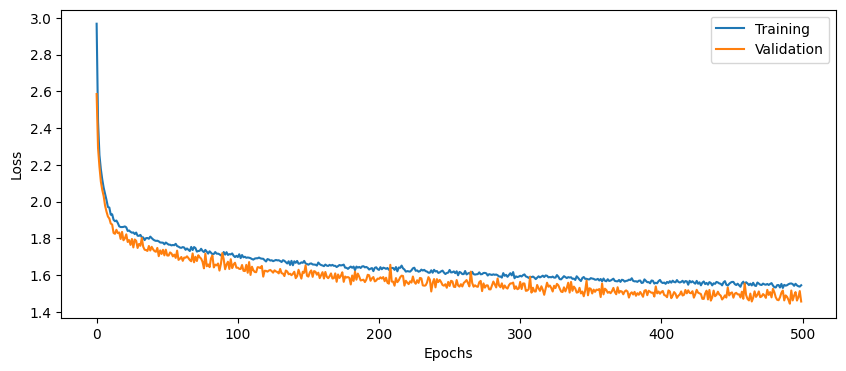

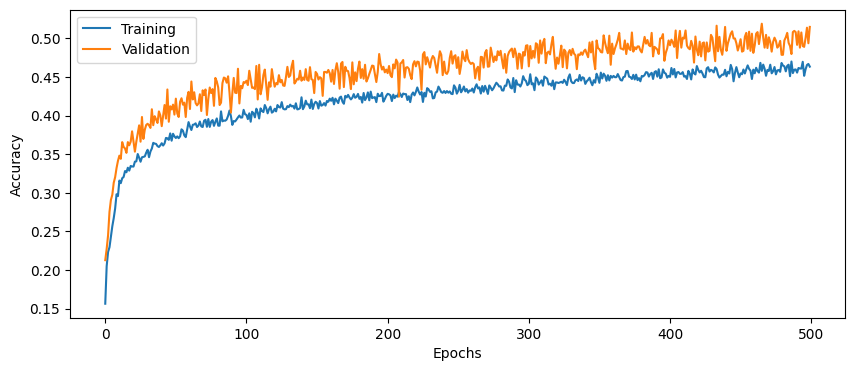

In [23]:
# Plot the history from the training run
from utilities import plot_results
plot_results(history6)

## Plot misclassified images

Lets plot some images where the CNN performed badly.

In [24]:
# Find misclassified images
y_pred=model6.predict(Xtest, verbose=0) 
y_pred=np.argmax(y_pred,axis=1)

y_correct = np.argmax(Ytest,axis=-1)

miss = np.flatnonzero(y_correct != y_pred)

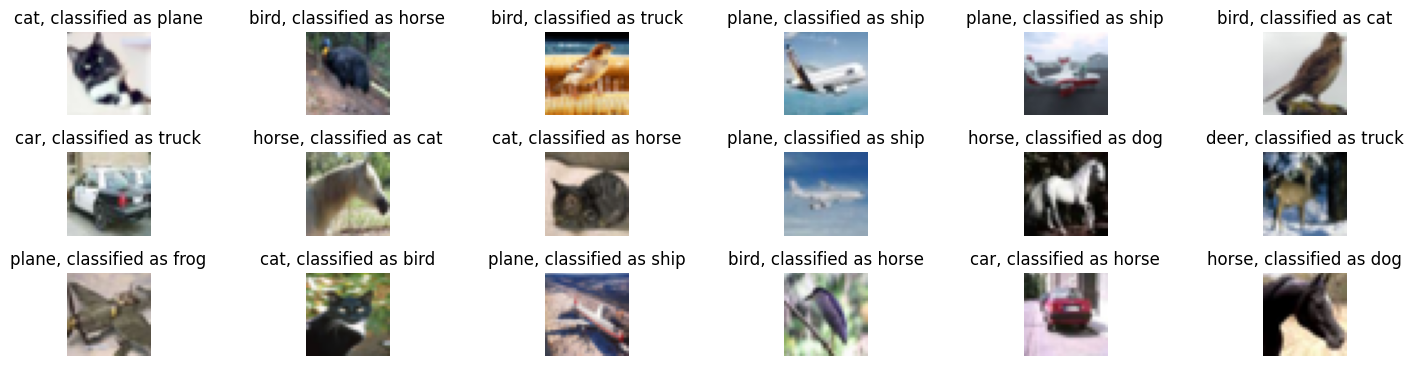

In [25]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  5.3 Testing on another size

#### **<span style="color:red">Questions</span>**

28. This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?

29. Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?

#### **<span style="color:green">Answers</span>**

28. Not really - if one tries to feed it an image of a different size, the dimensions of the feature maps will change, causing a mismatch in the input size to the dense layers and resulting in an error.

29. Yes, for instance, using GlobalAveragePooling2D or GlobalMaxPooling2D as the pooling layer.

# Part 6: Carbon footprint

In this next section we will evaluate the carbon footprint of training our CNN model. In particular we will look at the effect of training hyper parameters of carbon footprint. You can read more about this topic [here](https://arxiv.org/abs/2007.03051) or [here](https://research.google/blog/good-news-about-the-carbon-footprint-of-machine-learning-training/). 

In this lab we will use the `carbontracker` library that easily integrates with any model training routine. See the example in the [documentation](https://github.com/lfwa/carbontracker?tab=readme-ov-file) on how to use the carbon tracker.

#### **<span style="color:red">Questions</span>**

28. Keeping the model architecture fixed, which training parameter impacts the carbon footprint? 
    
29. The choice of batch size can dramatically impact carbon foot print: why is this the case?
    
30. Assume that you have a model with 100 million parameters running in the backend of a service with 5 million users. How can the carbon footprint of using this model be reduced?

#### **<span style="color:green">Answers</span>**

28, 29. Batch size. A smaller batch size requires more iterations per epoch to process the same number of samples, increasing energy consumption. Although on this system and with this model the footprint is minimal (near zero) even if batch size is 1 (see below).

30. Probably using a simpler model that approximates the original model performance but has fewer parameters. Using transfer learning. Choosing locations with greener data centers, like Iceland or Paraguay. Using energy-efficient hardware.

In [35]:
from carbontracker.tracker import CarbonTracker

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
# Setup training parameters
batch_size = 1
epochs = 10
input_shape = input_shape

# Build model (your best config)
model7 = build_CNN(input_shape=input_shape, 
                   loss=CategoricalCrossentropy(),
                   learning_rate=0.0005, 
                   n_dense_layers=1, 
                   n_conv_layers=3,
                   use_dropout=True, 
                   l2_regularization=True, 
                   optimizer="adam"
)

# Create a CarbonTracker object
tracker = CarbonTracker(epochs=epochs)

# start carbon tracking
tracker.epoch_start()

# fit model
model.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=epochs, batch_size=batch_size)

tracker.epoch_end()

# ============================================


CarbonTracker: The following components were found: CPU with device(s) cpu:0.
No sudo access to read Intel's RAPL measurements from the energy_uj file.
See issue: https://github.com/lfwa/carbontracker/issues/40
Epoch 1/10
CarbonTracker: WARNING - ElectricityMaps API key not set. Will default to average carbon intensity.15       
CarbonTracker: WARNING - Failed to retrieve carbon intensity: Defaulting to average carbon intensity 40.694878 gCO2/kWh.
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.1735 - loss: 2.8408 - val_accuracy: 0.1967 - val_loss: 2.2148
Epoch 2/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.1815 - loss: 2.1756 - val_accuracy: 0.1980 - val_loss: 2.1431
Epoch 3/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.2255 - loss: 2.1022 - val_accuracy: 0.2387 - val_loss: 2.0899
Epoch 4/10
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.2616 - loss: 2.0199 - val_accuracy: 0.3147 - val_loss: 1.9601
Epoch 5/10
7000/7000 ━━━━━━━━━━━━━━

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Read timed out. (read timeout=5.0)


CarbonTracker: INFO - Traceback (most recent call last):
  File "/opt/liu/course-venv-732a82/2/1/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 114, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: WARNING - ElectricityMaps API key not set. Will default to average carbon intensity.
CarbonTracker: WARNING - Failed to retrieve carbon intensity: Defaulting to average carbon intensity 40.694878 gCO2/kWh.
CarbonTracker: WARNING - ElectricityMaps API key not set. Will default to average carbon intensity.
CarbonTracker: WARNING - Failed to retrieve carbon intensity: Defaulting to average carbon intensity 40.694878 gCO2/kWh.
CarbonTracker: WARNING - ElectricityMaps API key not set. Will default to average carbon intensity.
CarbonTracker: WARNING - Failed to retrieve carbon intensity: Defaulting to average carb

# Part 7: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database (several million images, 1000 classes). Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

#### **<span style="color:red">Questions</span>**

31. How many convolutional layers does ResNet50 have? 

32. How many trainable parameters does the ResNet50 network have? 

33. What is the size of the images that ResNet50 expects as input?

34. Using the answer to question 30, explain why the second derivative is seldom used when training deep networks.

35. What do you expect the carbon footprint of using pre-trained networks to be compared to training a model from scratch?

#### **<span style="color:green">Answers</span>**

31. 49 convolutional layers
32. 25583592 parameters
33. 224x224 pixels with 3 color channels (RGB)
34. The second derivative is rarely used in deep network training because of huge computational cost and memory cost, higher carbon footprint and efficiency of optimization methods that use only first derivatives (SGD, Adam etc)
35. There will be much lower carbon footprint because networks are pretrained and one needs only fine-tuning.


After loading the pre-trained CNN, apply it to 5 random color images that you download and copy to the cloud machine or your own computer. Are the predictions correct? How certain is the network of each image class?

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this elaboration.

Some useful functions:
- `load_img` and `img_to_array` in [tf_keras.utils](https://www.tensorflow.org/api_docs/python/tf/keras/utils).
- `ResNet50` in [tf_keras.applications.ResNet50](tf.keras.applications.ResNet50).
- `preprocess_input` in [tf_keras.applications.resnet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input).
- `decode_predictions` in [tf_keras.applications.resnet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/decode_predictions).
- `expand_dims` in [numpy](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html).

See [keras applications](https://keras.io/api/applications/) and the keras [resnet50-function](https://keras.io/api/applications/resnet/#resnet50-function) for more details.

In [38]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
# import the necessary libraries and functions 
from tf_keras.applications import ResNet50
from tf_keras.utils import load_img, img_to_array
from tf_keras.applications.resnet import preprocess_input, decode_predictions

# load the pre-trained ResNet50 model
resnet50 = ResNet50(weights="imagenet")

# print the model summary
resnet50.summary()

# load the image and preprocess it
image = load_img("cat1.jpg", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

# predict the image
preds = resnet50.predict(image)
label = decode_predictions(preds, top=1)[0]

# print the predicted label
print(label)

# load the image and preprocess it
image = load_img("cat2.jpg", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

# predict the image
preds = resnet50.predict(image)
label = decode_predictions(preds, top=1)[0]

# print the predicted label
print(label)

# load the image and preprocess it
image = load_img("cat3.jpg", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

# predict the image
preds = resnet50.predict(image)
label = decode_predictions(preds, top=1)[0]

# print the predicted label
print(label)

# load the image and preprocess it
image = load_img("cat4.jpg", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

# predict the image
preds = resnet50.predict(image)
label = decode_predictions(preds, top=1)[0]

# print the predicted label
print(label)

# load the image and preprocess it
image = load_img("cat5.jpg", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

# predict the image
preds = resnet50.predict(image)
label = decode_predictions(preds, top=1)[0]

# print the predicted label
print(label)

# ============================================

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

# Part 8 (OPTIONAL)

Set up `Ray Tune` and run automatic hyper parameter optimization for the CNN model as we have done in the DNN lab. Remember that you have to define the `train_CNN` function, specify the hyper parameter search space and the number of samples to evaluate, among other.